## Introduction
##### Here, we are going to implement Black-Scholes model in python and see some of its features.

### Importing Libraries

In [109]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from skopt import gp_minimize as gpm

import warnings
warnings.filterwarnings("ignore")

##### Now, let us create our first class to define BS model and some features that we will use.

##### But, to do this, we need the Black-Scholes close solution form, and it is:
$$
C = SN(d_1)-Ke^{-rT}N(d_2),\,\,\,\,\,\,\,\,\,
$$
$$
P = Ke^{-rT}N(-d_2) - SN(-d_1).
$$
##### Where:
$$
d_1 = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^2}{2})T}{\sigma\sqrt{T}}\qquad\qquad\quad\,\,\,
$$
$$
d_2 = \frac{ln(\frac{S}{K})+(r-\frac{\sigma^2}{2})T}{\sigma\sqrt{T}} = d_1 - \sigma\sqrt{T}
$$


In [213]:
class BlackScholes():
    def __init__(self, r, S, K, T, sigma, opt_type, real_price = 10.0, 
                sigma_series=np.linspace(0,3,10).reshape(1,-1), 
                round_price = False, decimal_places = 2, ext_text = False):
        self.r = r
        self.S = S
        self.K = K
        self.T = T/365
        self.T_days = T
        self.sigma = sigma
        self.opt_type = opt_type
        self.round_price = round_price
        self.decimal_places = decimal_places
        self.ext_text = ext_text
        self.real_price = real_price
        self.sigma_series = sigma_series


    def price(self):
        self.d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2) * self.T)/(self.sigma * np.sqrt(self.T))
        self.d2 = self.d1 - self.sigma*np.sqrt(self.T)
        
        if self.opt_type == "Call":
            self.opt_price = self.S*sts.norm.cdf(self.d1, 0, 1) - self.K*np.exp(-self.r*self.T)*sts.norm.cdf(self.d2, 0, 1)
        elif self.opt_type == "Put":
            self.opt_price = self.K*np.exp(-self.r*self.T)*sts.norm.cdf(-self.d2, 0, 1) - self.S*sts.norm.cdf(-self.d1, 0, 1)
        
        if self.round_price:
            self.opt_price = round(self.opt_price, self.decimal_places)

        if self.ext_text:
            if self.opt_type == "Call":
                print(f'The price of a Call Option with parameters (r={self.r}, S={self.S}, K={self.K}, T={self.T_days}/365, sigma={self.sigma}) is: {self.opt_price}')
            elif self.opt_type == "Put":
                print(f'The price of a Put Option with parameters (r={self.r}, S={self.S}, K={self.K}, T={self.T_days}/365, sigma={self.sigma}) is: {self.opt_price}')
        else:
            return self.opt_price 
        

    def optm(self, sigma_series):
        self.sigma = np.array(sigma_series)
        return np.abs(self.price()[0]-self.real_price)


    def implied_volatility(self, n_calls=35):
        return     gpm(self.optm,                                 # the function to minimize
                        [(0, 4.0)],                               # the bounds on each dimension of x
                        acq_func="EI",                            # the acquisition function
                        n_calls=n_calls,                          # the number of evaluations of f
                        n_random_starts=5,                        # the number of random initialization points
                        #noise=0.1**2,                            # the noise level (optional)
                        random_state=1234).x[0]                   # the random seed

With this Class, we can compute the option pricing with the BS model.

So before any calculations, lets understand how do prices behave varying some parameters.

In [87]:
BlackScholes(r = 0.01, S = 30, K = 40, T = 240, sigma = 0.3, opt_type = "Put", round_price = True, ext_text=True).price()
BlackScholes(r = 0.01, S = 30, K = 40, T = 240, sigma = 0.3, opt_type = "Call", round_price = True, ext_text=True).price()

The price of a Put Option with parameters (r=0.01, S=30, K=40, T=240/365, sigma=0.3) is: 10.25
The price of a Call Option with parameters (r=0.01, S=30, K=40, T=240/365, sigma=0.3) is: 0.51


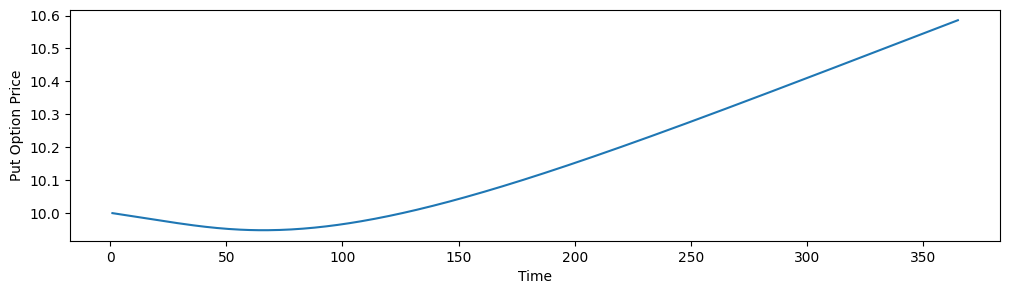

In [235]:
X = np.linspace(1,365,365)
Y = BlackScholes(r = 0.01, S = 30, K = 40, T = X, sigma = 0.3, opt_type = "Put", round_price = False).price()
plt.figure(figsize=(12,3))
plt.plot(X,Y)
plt.xlabel('Time')
plt.ylabel("Put Option Price")
plt.show()

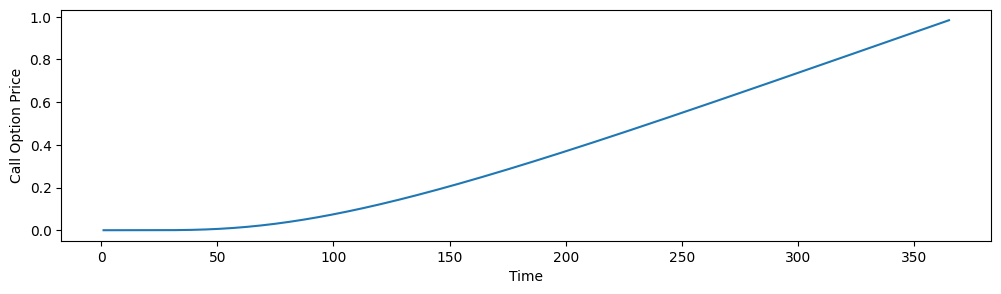

In [234]:
X = np.linspace(1,365,365).reshape(-1,1)
Y = BlackScholes(r = 0.01, S = 30, K = 40, T = X, sigma = 0.3, opt_type = "Call", round_price = False).price()
plt.figure(figsize=(12,3))
plt.plot(X,Y)
plt.xlabel('Time')
plt.ylabel("Call Option Price")
plt.show()

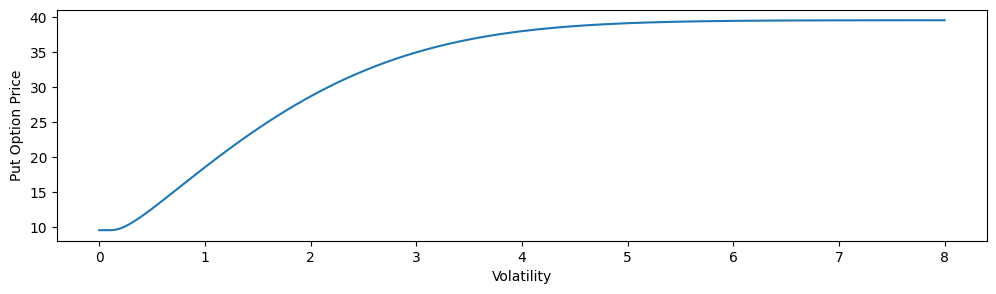

In [237]:
X = np.linspace(0,8,1000)
Y = BlackScholes(r = 0.01, S = 30, K = 40, T = 365, sigma = X, opt_type = "Put", round_price = False).price()
plt.figure(figsize=(12,3))
plt.plot(X,Y)
plt.xlabel('Volatility')
plt.ylabel("Put Option Price")
plt.show()

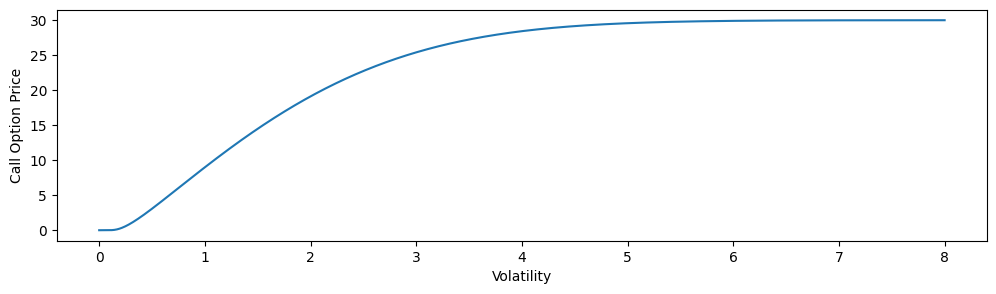

In [238]:
X = np.linspace(0,8,1000)
Y = BlackScholes(r = 0.01, S = 30, K = 40, T = 365, sigma = X, opt_type = "Call", round_price = False).price()
plt.figure(figsize=(12,3))
plt.plot(X,Y)
plt.xlabel('Volatility')
plt.ylabel("Call Option Price")
plt.show()

Now, we can visualize that if $\sigma>5$, bayesian optimization will struggle to give a satisfactory answer. So let's contain our analysis on the complementary set.

In [226]:
real_price=30.0

implied_volatility = BlackScholes(r = 0.01, S = 30, K = 40, T = 240, sigma = 0.3, real_price=real_price, opt_type = "Put").implied_volatility()
result = BlackScholes(r = 0.01, S = 30, K = 40, T = 240, sigma = implied_volatility, real_price=real_price, opt_type = "Put").price()

print(f"The implied volatility, calculated with bayesian optimization is: \n {result}")

The implied volatility, calculated with bayesian optimization is: 
 30.001518317683573


In [232]:
error = np.abs(real_price - result)*100/real_price
print(f"With and error given by: {round(error,5)}%")

With and error given by: 0.00506%
